### Import Dependencies

In [ ]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

## Import Data

Import data from the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Data

In [ ]:
train_dir ="/content/drive/MyDrive/dataset2-master/dataset2-master/images/TRAIN"
test_dir ="/content/drive/MyDrive/dataset2-master/dataset2-master/images/TEST"

In [ ]:

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


### Building Pretrained Model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

### Build Classification Model

In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

### Check GPU Devices

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Training

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
249/249 [==============================] - 3693s 15s/step - loss: 0.8241 - accuracy: 0.6611 - val_loss: 0.6003 - val_accuracy: 0.7712
Epoch 2/100
249/249 [==============================] - 34s 137ms/step - loss: 0.4757 - accuracy: 0.8223 - val_loss: 0.4581 - val_accuracy: 0.8160
Epoch 3/100
249/249 [==============================] - 34s 137ms/step - loss: 0.3632 - accuracy: 0.8626 - val_loss: 0.4466 - val_accuracy: 0.8079
Epoch 4/100
249/249 [==============================] - 34s 138ms/step - loss: 0.2830 - accuracy: 0.8991 - val_loss: 0.3630 - val_accuracy: 0.8547
Epoch 5/100
249/249 [==============================] - 34s 138ms/step - loss: 0.2221 - accuracy: 0.9227 - val_loss: 0.2816 - val_accuracy: 0.8919
Epoch 6/100
249/249 [==============================] - 34s 136ms/step - loss: 0.1934 - accuracy: 0.9352 - val_loss: 0.4234 - val_accuracy: 0.8321
Epoch 7/100
249/249 [==============================] - 34s 137ms/step - loss: 0.1507 - accuracy: 0.9478 - val_loss: 0.2950 -

### Results

In [ ]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()


### Different Classes

In [ ]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

Test Accuracy: 53.197%


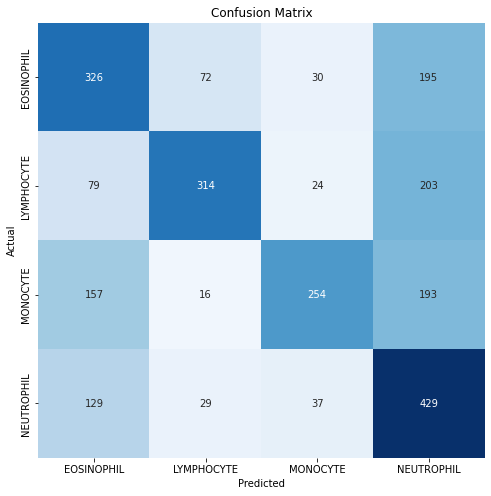

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.47      0.52      0.50       623
  LYMPHOCYTE       0.73      0.51      0.60       620
    MONOCYTE       0.74      0.41      0.53       620
  NEUTROPHIL       0.42      0.69      0.52       624

    accuracy                           0.53      2487
   macro avg       0.59      0.53      0.54      2487
weighted avg       0.59      0.53      0.54      2487



In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

Found 1989 images belonging to 4 classes.
Validation Accuracy: 93.967%


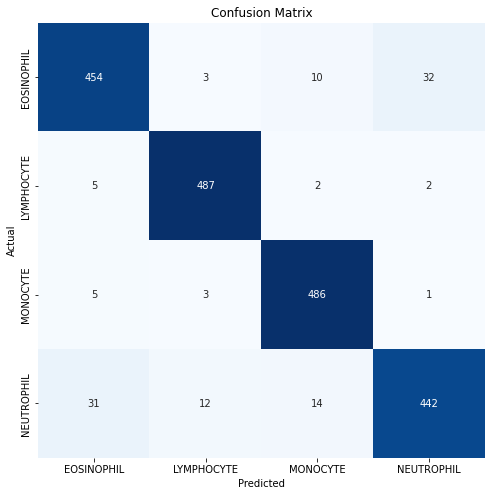

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.92      0.91      0.91       499
  LYMPHOCYTE       0.96      0.98      0.97       496
    MONOCYTE       0.95      0.98      0.97       495
  NEUTROPHIL       0.93      0.89      0.91       499

    accuracy                           0.94      1989
   macro avg       0.94      0.94      0.94      1989
weighted avg       0.94      0.94      0.94      1989



In [ ]:
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='validation'
)


predictions = np.argmax(model.predict(val_images), axis=1)

acc = accuracy_score(val_images.labels, predictions)
cm = tf.math.confusion_matrix(val_images.labels, predictions)
clr = classification_report(val_images.labels, predictions, target_names=CLASS_NAMES)

print("Validation Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)